# Importing file dependencies for the code.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import astropy_mpl_style
from glob import glob
import os
import numpy as np
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import optimize
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore", module='astropy.wcs.wcs')
from astropy.timeseries import LombScargle


# Setting defaults for the plots.

In [2]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['errorbar.capsize'] = 3
opts = {'mec':'k', 'mew': 0.5, 'lw': 1}

# Importing the fits files.

In [3]:
#importing the data from the base directory, and adding the names to a variable with glob
datadir = '/home/taterz/V453Cyg_data/'
fnames = glob(os.path.join(datadir, '*.fits'))

data_month1 = fits.getdata(fnames[0], ext=1)
data_month2 = fits.getdata(fnames[1], ext=1)

# get quality flag of 0 for each set of data
flag_check1 = data_month1['QUALITY'] == 0
lc_data_month1 = data_month1[flag_check1]

flag_check2 = data_month2['QUALITY'] == 0
lc_data_month2 = data_month2[flag_check2]

## Defining some functions to be used later. They work like subroutines.

In [4]:
def remove_eclipse(flux, eclp_flux): 
    """Removes the eclipsing dips from the flux. Uses fits file flux data and a number 
        for the estimated eclipse flux count. 
    
    'flux' - filtered fits data array containing flux values
    'eclp_flux' - value for the eclipse flux
    
    'flux_eclp_rm - further filtered fits data array holding removed eclipse data'
    """

    #applies a truth check to filter out values above the value given from input
    flag_check_flux = flux['SAP_FLUX'] >= eclp_flux
    flux_eclp_rm = flux[flag_check_flux]
    
    
    return flux_eclp_rm

Using this new function to remove the eclipse from the first month's data.

(1700, 1705)

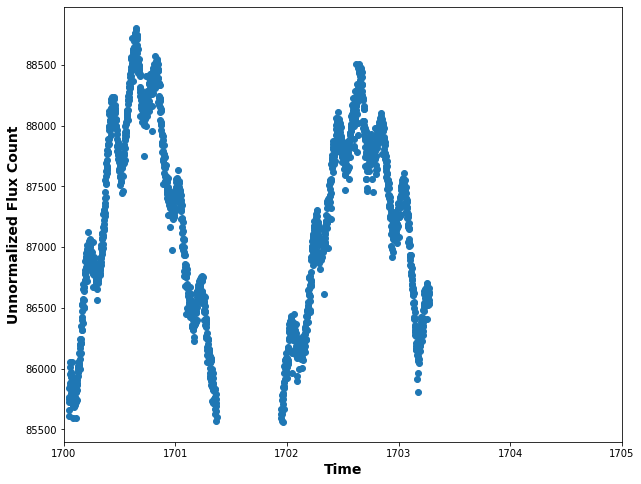

In [5]:
month1_eclp_rm = remove_eclipse(lc_data_month1, 85560)
plt.scatter(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'])
plt.xlabel("Time")
plt.ylabel("Unnormalized Flux Count")
plt.xlim(1700,1705)

In [6]:
def lomb_scargle(times, flux):
    """Takes the time list and flux to determine the most probable frequency.
        Returns value for the frequencies, power ratings, and max period.
    
    'times' - list holding the time measurements
    'flux' - list holding the flux measurements
    """
    freq, power = LombScargle(times, flux).autopower()
    max_period = 1 / freq[np.argmax(power)]
    
    return freq, power, max_period

Using the above function to determine the estimated period of the major curve.

In [7]:
freq_month1, pow_month1, max_period_month1 = lomb_scargle(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'])

In [8]:
def losc_plot(freq, power, period):
    """Simple function to plot the values for the lomb scargle output.
    
    'freq' - list holding the frequencies 
    'power' - list holding the relative power values
    'period' - value for the maximum power frequency corresponding to the period
    
    """
    
    plt.plot(freq, power, 'r', lw=5)
    plt.ylabel('Power')
    plt.xlabel('Frequency (1/day)')
    print("The max period is:", '%.5f'%period, "days.")

The max period is: 1.93167 days.


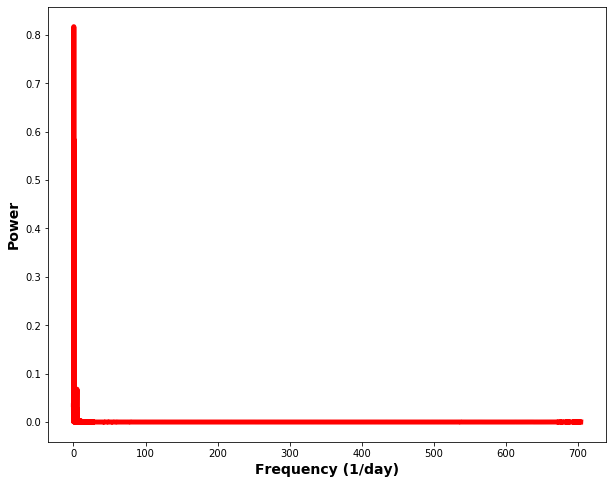

In [9]:
losc_plot(freq_month1, pow_month1, max_period_month1)

In [10]:
def phase_fold_plot(times, flux, period):
    """Creates a plot of the phase folded flux based on the max period.
    
    'times' - array holding the time values
    'flux' - array holding the flux values
    'period' - value for the max period
    
    """
    #period = 3.89
    plt.plot(times % period, flux, 'r+');
    plt.xlabel('Phase (days)')
    plt.ylabel('Magnitude')
    plt.grid();

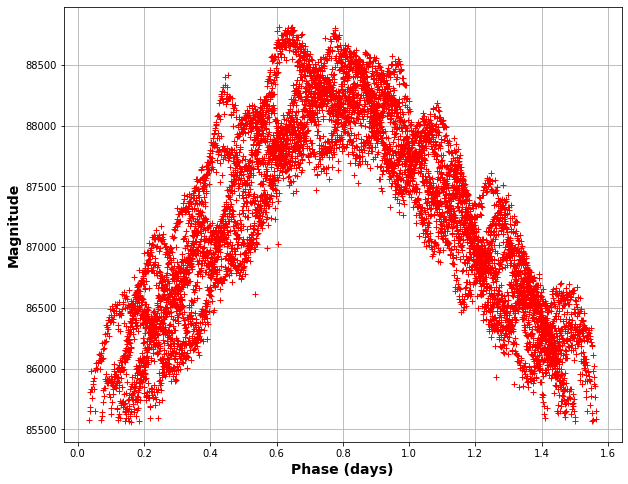

In [11]:
phase_fold_plot(month1_eclp_rm['TIME'], month1_eclp_rm['SAP_FLUX'], max_period_month1)

In [12]:
def sine_func(x, a, b, c):
    return a * np.sin(b*x + c)

def curve_fitter(times, fluxes, period, func, amp):
    """Uses scipy's curve fit function to find a best fitted function based on
        user's input function.
        
    'times' - array holding the time values
    'fluxes' - array holding the flux values
    'period' - estimated period of the trend
    'func' - function to be fitted
    'amp' - initial estimate of the amplitude
    
    'params' - parameters for the fitted function
    'pcovar' - covariance of the parameters
    """
    fold_times = times % period
    params, pcovar = curve_fit(func, fold_times, fluxes, p0=[amp, period, 0])
    
    return params

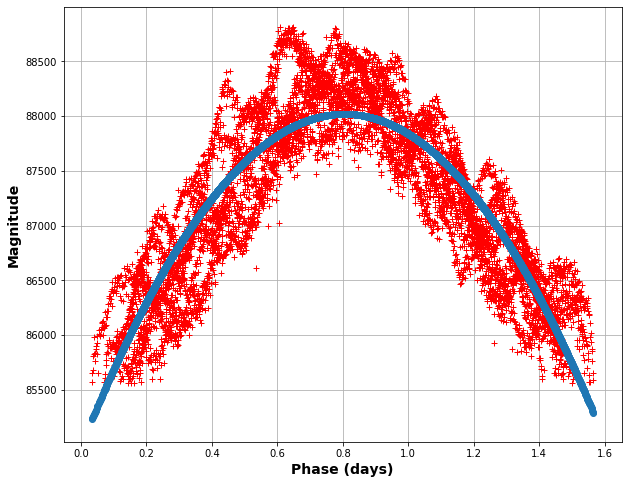

In [13]:
#making a new variable to hold the times, fold times and fluxes for the first month
#should have been done earlier, but the fits array was needed to remove the eclipse
fold_times_m1 = month1_eclp_rm['TIME'] % max_period_month1
times_m1 = month1_eclp_rm['TIME']
fluxes_m1 = month1_eclp_rm['SAP_FLUX']

phase_fold_plot(times_m1, fluxes_m1, max_period_month1)

params_m1 = curve_fitter(fold_times_m1, fluxes_m1, max_period_month1, sine_func, 1200)

#the fitted function, zorder of value 10 prioritizes its layering on top
plt.scatter(fold_times_m1, params_m1[0]*np.sin(params_m1[1]*fold_times_m1 + params_m1[2]),zorder=10)

In [14]:
def detrend(fold_times, fluxes, params, func):
    """Detrends the data based on the fitted function.
        
    'fold_times' - array holding the folded time values
    'fluxes' - array holding the flux values
    'func' - function to be fitted    
    'params' - parameters for the fitted function

    """
    #using the fitted model function to detrend the data
    y_fit = func(fold_times, params[0], params[1], params[2])
    flux_detrended = fluxes - y_fit
    
    return flux_detrended

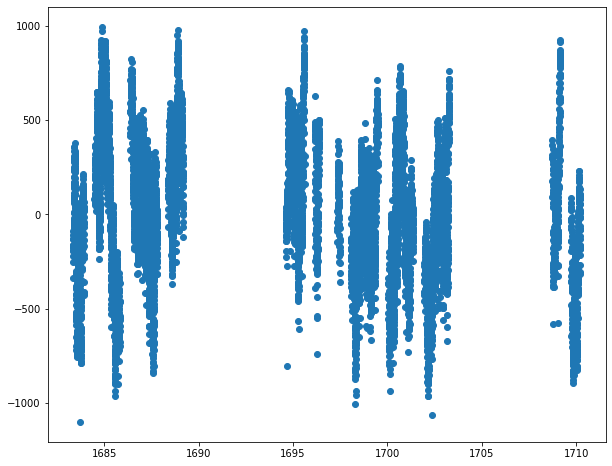

In [15]:
flux_m1_dtrd = detrend(fold_times_m1, fluxes_m1, params_m1, sine_func)
plt.scatter(times_m1, flux_m1_dtrd)

The max period is: 0.20234 days.


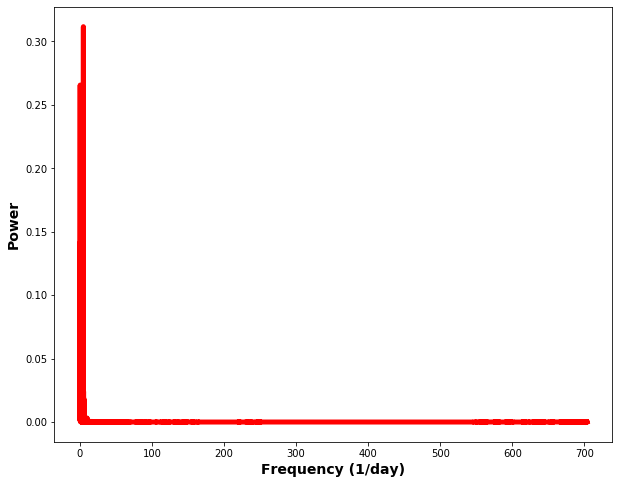

In [16]:
#using the detrended data to find and remove the smaller humps
losc_dtrd = lomb_scargle(times_m1, flux_m1_dtrd)
losc_plot(losc_dtrd[0],losc_dtrd[1],losc_dtrd[2])

### With the major hump gone, it should be a simple matter of repeating the earlier steps to determine and remove the secondary hump.

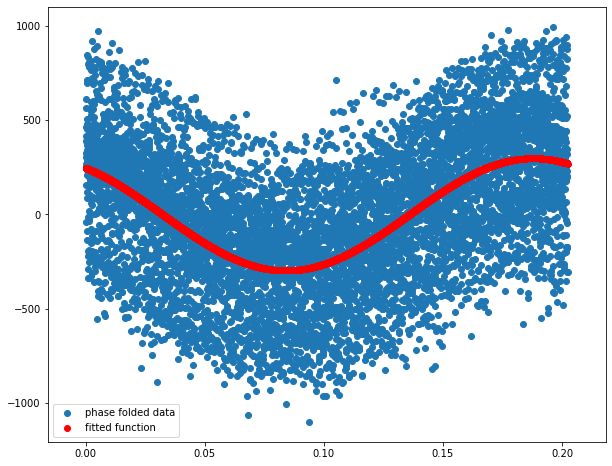

In [17]:
#since this is the second hump, times will be signified by h2
fold_times_m1_h2 = times_m1%losc_dtrd[2]
params_m1_h2 = curve_fitter(times_m1, flux_m1_dtrd, losc_dtrd[2], sine_func, 100)
plt.scatter(fold_times_m1_h2, flux_m1_dtrd, label='phase folded data')

#likewise, the secondary fitted function will be signified by 2
y2_fit = sine_func(fold_times_m1_h2, params_m1_h2[0], params_m1_h2[1], params_m1_h2[2])
plt.scatter(fold_times_m1_h2, y2_fit, color='red', label='fitted function')
plt.legend()

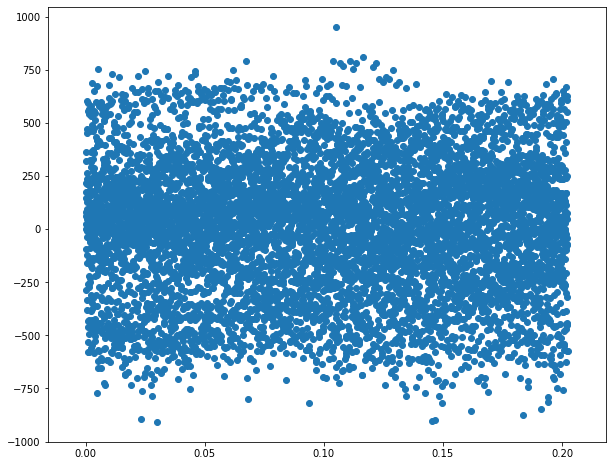

In [18]:
#running through the detrend function in order to remove the small humps
flux_m1_dtrd_h2 = detrend(fold_times_m1_h2, flux_m1_dtrd, params_m1_h2, sine_func)
plt.scatter(fold_times_m1_h2, flux_m1_dtrd_h2)

The max period is: 0.00001 days.


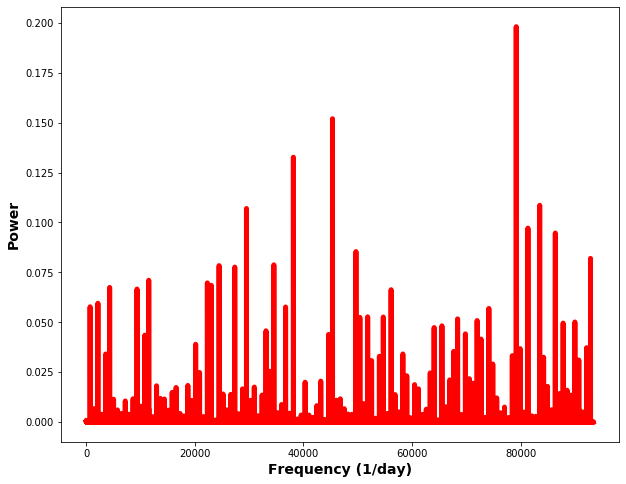

In [19]:
losc_dtrd_h3 = lomb_scargle(fold_times_m1_h2, flux_m1_dtrd_h2)
losc_plot(losc_dtrd_h3[0], losc_dtrd_h3[1], losc_dtrd_h3[2])

### Data looks relatively well detrended, so now I try to remove the function from the original data to hopefully detrend the smaller humps.

(1683, 1688)

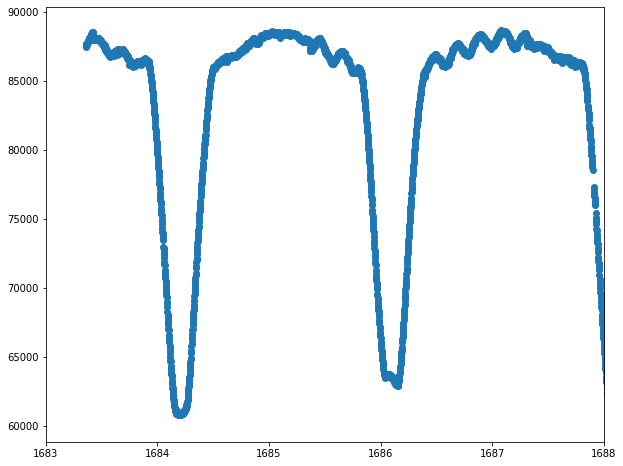

In [20]:
times_m1_full = lc_data_month1['TIME']
times_m1_full_fold = times_m1_full % (max_period_month1 + 0.01)
flux_m1_full = lc_data_month1['SAP_FLUX']

#params_fitted = [200, params_m1_h2[1], params_m1_h2[2]]
final_data_m1 = detrend(times_m1_full_fold, flux_m1_full, params_m1_h2, sine_func)

#plt.scatter(times_m1_full_fold, final_data_m1)
plt.scatter(times_m1_full, final_data_m1)
plt.xlim(1683,1688)

In [21]:
import csv
with open('detrended_data.csv', mode='w') as detrended_data:
    detrended_writer = csv.writer(detrended_data, delimiter=' ')
    for i in range(len(final_data_m1)):
        detrended_writer.writerow([times_m1_full[i], final_data_m1[i]])

(1693, 1696)

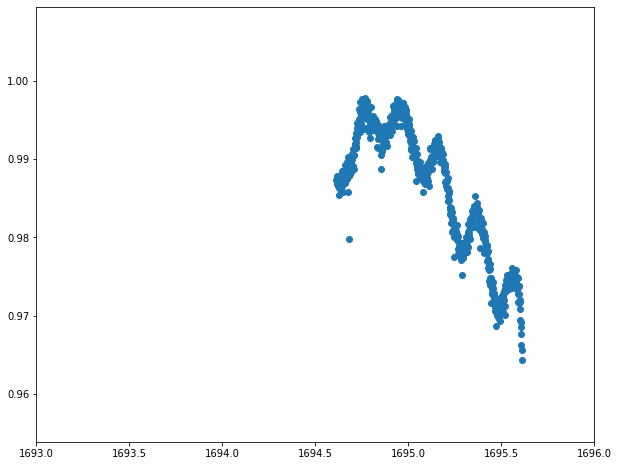

In [39]:
#fluxes_norm = fluxes_m1/fluxes_m1.argmax()
#plt.scatter(times_m1, fluxes_norm)
#print(fluxes_norm)
norm = np.amax(fluxes_m1)
fluxes_norm = fluxes_m1/norm
plt.scatter(times_m1, fluxes_norm)
plt.xlim(1693,1696)

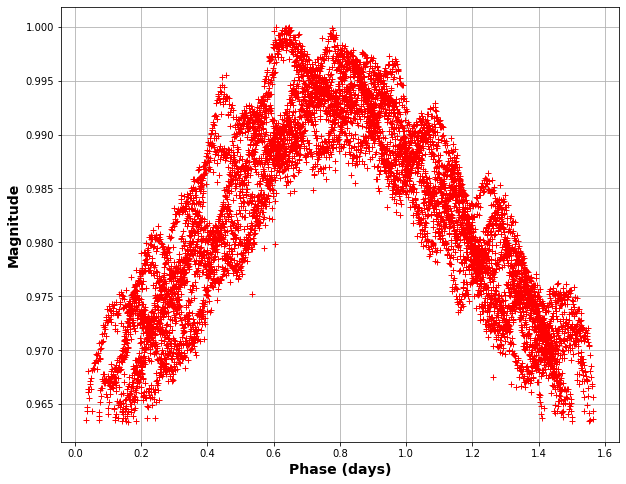

In [41]:
freq1, pow1, period1 = lomb_scargle(times_m1, fluxes_norm)
phase_fold_plot(times_m1, fluxes_norm, period1)

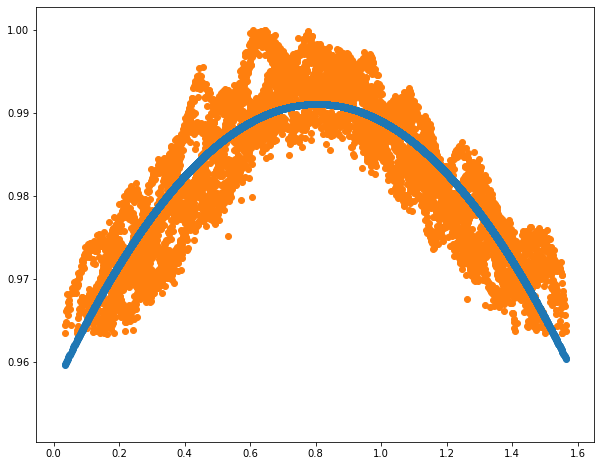

In [47]:
fold_times = times_m1%period1
params_maj_gone = curve_fitter(fold_times, fluxes_norm, period1, sine_func, 1)
maj_gone = detrend(times_m1%period1, fluxes_norm, params_maj_gone, sine_func)
y_maj_gone = params_maj_gone[0]*np.sin(params_maj_gone[1]*fold_times + params_maj_gone[2])

plt.scatter(fold_times, y_maj_gone, zorder=10)
plt.scatter(fold_times, fluxes_norm)

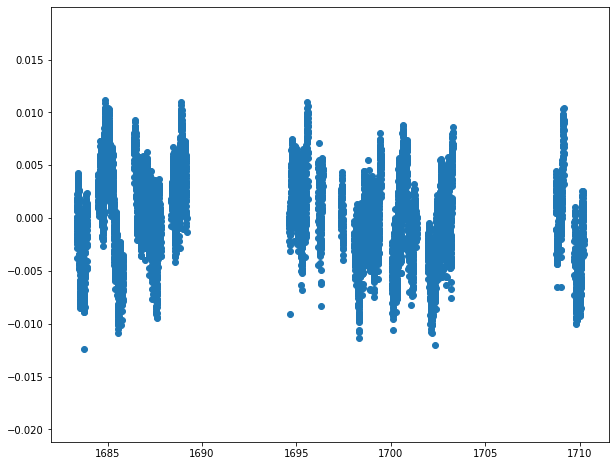

In [50]:
new_fluxes = fluxes_norm - y_maj_gone
plt.scatter(times_m1, new_fluxes)

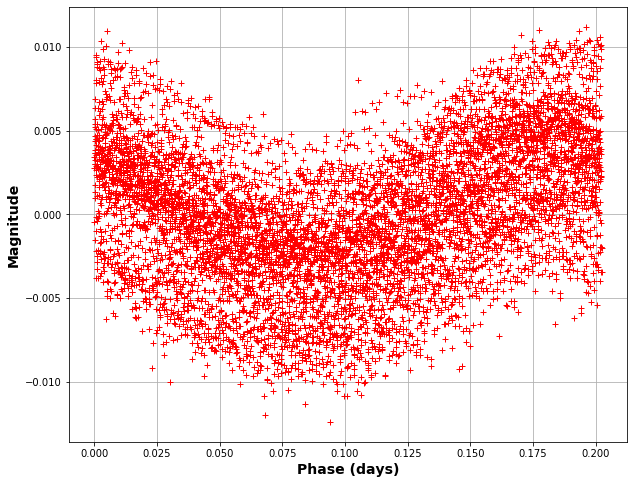

In [51]:
freq2, pow2, period2 = lomb_scargle(times_m1, new_fluxes)
phase_fold_plot(times_m1, new_fluxes, period2)

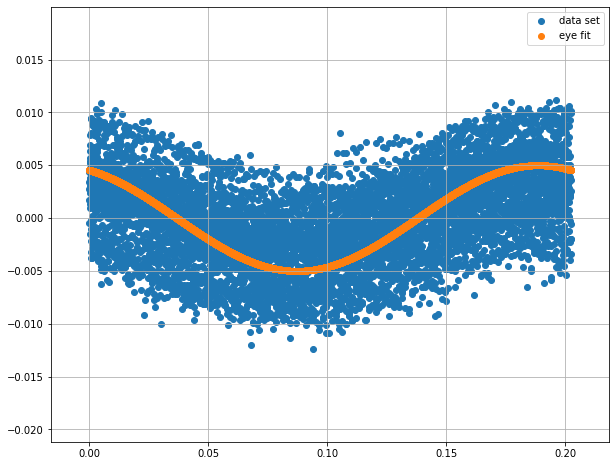

In [77]:
fold_times = times_m1 % period2
plt.scatter(fold_times, new_fluxes, label='data set')
plt.scatter(fold_times, 0.005*np.sin(times_m1*(2*np.pi)/period2 + 2), label='eye fit')
plt.grid()
plt.legend()

[ 3.35117116e-03  3.02648819e+01 -4.11548730e+00]
[1683.35711146 1683.35850038 1683.35988929 1683.3612782  1683.36266712
 1683.36405603 1683.36544494 1683.36683385 1683.36822277 1683.36961168]


(1683, 1685)

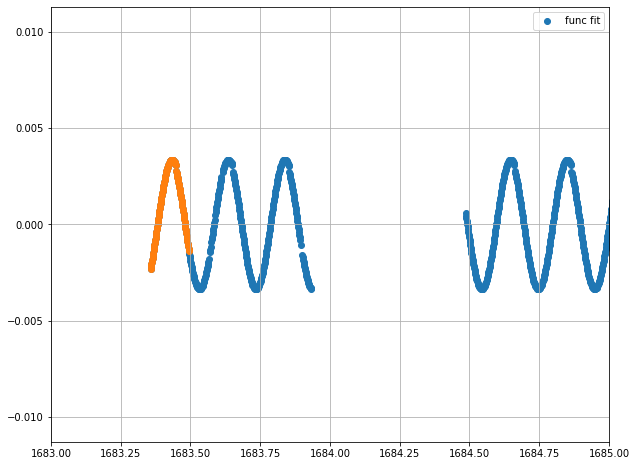

In [202]:
params_min_gone = curve_fitter(fold_times, new_fluxes, period2, sine_func, 0.005)
y_min = params_min_gone[0]*np.sin(params_min_gone[1]*fold_times + params_min_gone[2])
y_min_cut = params_min_gone[0]*np.sin(params_min_gone[1]*fold_times[0:100] + params_min_gone[2])

print(params_min_gone)
print(times_m1_full[0:10])
#plt.scatter(fold_times, new_fluxes, label='data set')
#plt.scatter(fold_times, 0.005*np.sin(times_m1*(2*np.pi)/period2 + 2), label='eye fit')
x = np.arange(0,len(y_min))
plt.scatter(times_m1, y_min, label='func fit')
plt.scatter(times_m1[0:100], y_min_cut)
plt.grid()
plt.legend()
plt.xlim(1683,1685)

Normalizing appeared to solve the issues I was having. The following three plots show the results of the anti wiggle detrending successfully (in a small window to showcase the results).

(1698, 1703)

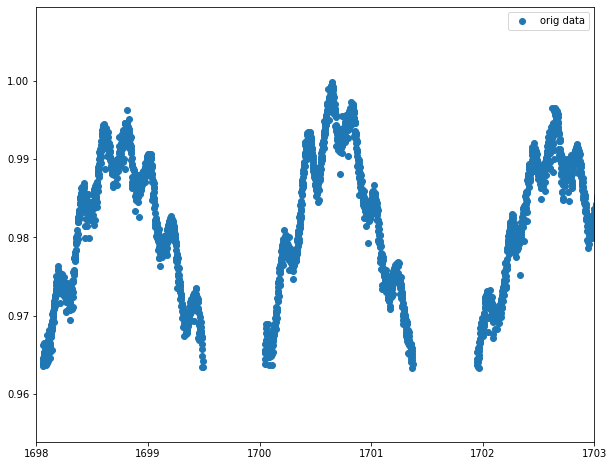

In [93]:
#plt.scatter(times_m1, y_maj_gone + y_min)
plt.scatter(times_m1, fluxes_norm, label='orig data')
#plt.scatter(times_m1, fluxes_norm - y_min, label='wiggle gone')
plt.legend()
plt.xlim(1698,1703)

No handles with labels found to put in legend.


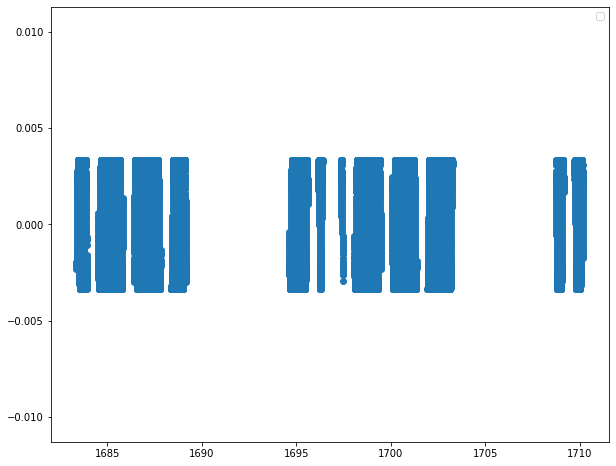

In [135]:
plt.scatter(times_m1, y_min)
#plt.scatter(times_m1, fluxes_norm, label='orig data')
#plt.scatter(times_m1, fluxes_norm - y_min, label='wiggle gone')
plt.legend()
#plt.xlim(1680,1690)

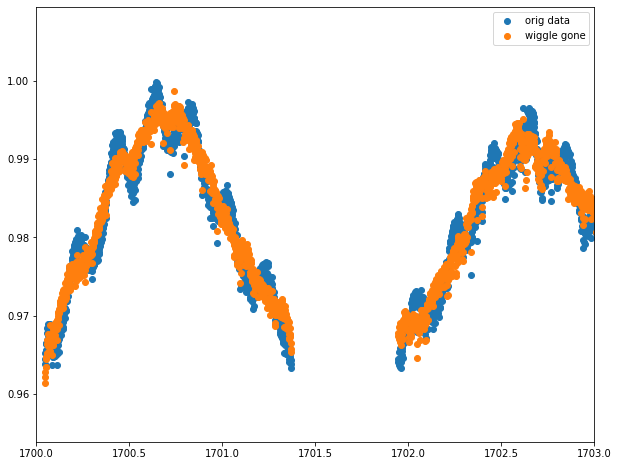

In [172]:
#plt.scatter(times_m1, y_maj_gone + y_min)
plt.scatter(times_m1, fluxes_norm, label='orig data')
plt.scatter(times_m1, fluxes_norm - y_min, label='wiggle gone')
plt.legend()
plt.xlim(1700,1703)
y_min_new = params_min_gone[0]*np.sin(params_min_gone[1]*fold_times + params_min_gone[2])

[ 3.35117116e-03  3.02648819e+01 -4.11548730e+00]
[1683.35711146 1683.35850038 1683.35988929 1683.3612782  1683.36266712
 1683.36405603 1683.36544494 1683.36683385 1683.36822277 1683.36961168]
[1683.35711146 1683.35850038 1683.35988929 1683.3612782  1683.36266712
 1683.36405603 1683.36544494 1683.36683385 1683.36822277 1683.36961168]
[-0.00335109 -0.00334911 -0.00334121 -0.00332741 -0.00330774]
[-0.00228917 -0.0021843  -0.00207557 -0.00196317 -0.00184731]
Difference: [-0.00106192 -0.00116481 -0.00126564 -0.00136424 -0.00146043]
[ 3.35117116e-03  3.02648819e+01 -4.11548730e+00]


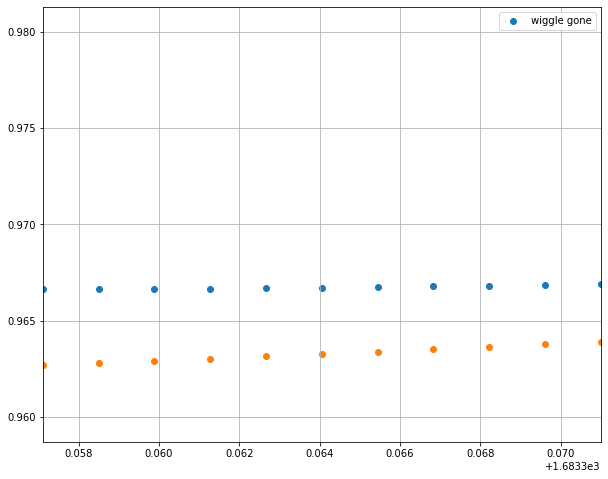

In [194]:
fluxes_full_norm = flux_m1_full/norm

y_min_gone = params_min_gone[0]*np.sin(params_min_gone[1]*times_m1_full + params_min_gone[2])
print(params_min_gone)
#plt.scatter(times_m1_full, fluxes_full_norm, label='orig data')
plt.scatter(times_m1_full, y_min_gone+0.97, label='wiggle gone')
#plt.scatter(times_m1, fluxes_norm, label='eclp gone', color='red')
plt.scatter(times_m1, y_min_new+0.965)
#plt.scatter(times_m1, y_maj_gone + y_min_gone, label='fitted')
plt.legend()
plt.grid()
plt.xlim(times_m1[0], times_m1_full[10])
#plt.ylim(0.95,1)
print(times_m1_full[0:10])
print(times_m1[0:10])
print(y_min_gone[0:5])
print(y_min[0:5])
print('Difference:', y_min_gone[0:5]-y_min[0:5])
print(params_min_gone)

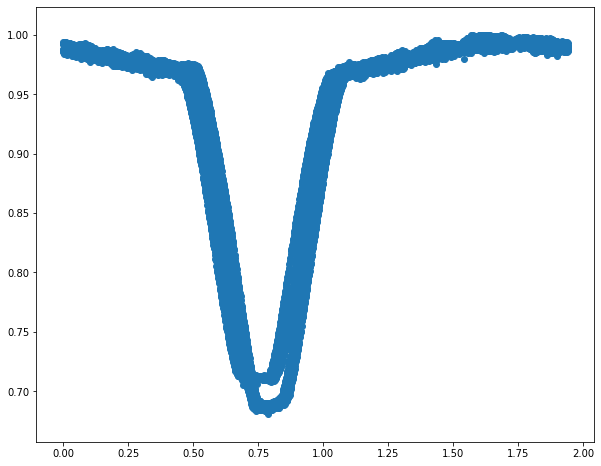

In [188]:
plt.scatter(times_m1_full_fold, fluxes_full_norm)

# Parameters for sine curve, Sine curve function:

In [205]:
print(params_min_gone)

y_min = params_min_gone[0] * np.sin( params_min_gone[1] * fold_times + params_min_gone[2] )

[ 3.35117116e-03  3.02648819e+01 -4.11548730e+00]
